# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Recherche de l'`architecture` la plus adaptée](#ARCHI)
    * [2.1 `Archi-REF` Bi-LSTM 32 + Dropout 0.5](#ARCHI_REF)
    * [2.2 `Archi-000` Dense 32 + Dropout 0.5](#ARCHI_000)
    * [2.3 `Archi-100` Simple RNN 32 + Dropout 0.5](#ARCHI_100)
    * [2.4 `Archi-200` LSTM 32 + Dropout 0.5](#ARCHI_200)
    * [2.5 `Archi-300` GRU 32 + Dropout 0.5](#ARCHI_300)
    * [2.6 `Archi-201` Bi-LSTM 64 + Dropout 0.5](#ARCHI_201)
    * [2.7 `Archi-202` Bi-LSTM 64 + Dense 24](#ARCHI_202)
    * [2.8 `Archi-301` Bi-GRU 64 + Dropout 0.5](#ARCHI_301)
    * [2.9 `Archi-302` Bi-GRU 64 + Dense 24](#ARCHI_302)
    * [2.10 `Archi-401` Bi-LSTM 32 + Dense 10](#ARCHI_401)
    * [2.11 `Archi-402` Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1](#ARCHI_402)
    * [2.12 `Archi-403` Dense 128 + Dropout 0.2 + Dense 64 + Dropout 0.2 + Dense 32 + Dropout 0.1](#ARCHI_403)
    * [2.13 Comparaison des scores](#ARCHI_scores)

In [1]:
import time
import pathlib
import gzip

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dagshub import dagshub_logger, DAGsHubLogger

try:
    from tensorflow.keras.layers import TextVectorization
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-08-08 15:28:12.681577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 15:28:12.681600: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-08-08 15:28:17.255848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-08 15:28:17.255886: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-08 15:28:17.255906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valkea-XPS): /proc/driver/nvidia/version does not exist


---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

### Chargeons quelques fonctions *maison* pour entrainer et évaluer les modèles, et initialisons un fichier pour enregistrer les scores
Ces fonctions ont été déportées dans le fichier classification_utils.py pour allèger le notebook

In [3]:
# Load classification helpers' functions & initialize a file to log the models' scores
from classification_utils import fit_model, get_scores, init_scores, find_best_threshold
init_scores("data/scores_NN_SelectArchitecture.csv")

### Chargeons le jeu de données et préparons un `échantillon de travail` représentatif

In [4]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'lemmas_not_filtered'],
    encoding='ISO-8859-1',
    #nrows=100000,
)
data_work.rename(columns={'lemmas_not_filtered':'text'}, inplace=True)
display(data_work.head(), data_work.shape)

# Select samples
sample_size = 100000
data_work = data_work.groupby('target', group_keys=False).apply(lambda x: x.sample(sample_size//2, random_state=random_seed))
display(data_work.head(), data_work.shape)

,target,text
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...
2,0,I dive many time for the ball . manage to save...
3,0,my whole body feel itchy and like its on fire
4,0,"no , it be not behave at all . I be mad . why ..."


(1452791, 2)

,target,text
469259,0,I do not have a background for my twitter stre...
152271,0,I do many thing but miss tweet
597612,0,most probably - eww all that pasty white skin ...
708306,0,"ohh , how bad I sleep"
59100,0,"hell yeah u be texte I I remember , I be at my..."


(100000, 2)

In [5]:
data_work.target.value_counts(dropna=False)

0    50000
1    50000
Name: target, dtype: int64

### Définissons les différentes `architectures RNN` que nous aimerions comparer

#### L'architecture utilisée sur les précèdents notebooks

In [6]:
# P.336 livre "Deep Learning with Python 2nd edition"
def architectureREF(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 32 + Dropout 0.5"

In [7]:
# P.323 livre "Deep Learning with Python 2nd edition"
def architecture000(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Dense(32)(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Dense 32 + Dropout 0.5"

#### Simple RNN / LSTM / GRU

In [8]:
# Simple RNN
def architecture100(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.SimpleRNN(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Simple RNN 32 + Dropout 0.5"

In [9]:
# LSTM 32
def architecture200(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.LSTM(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "LSTM 32 + Dropout 0.5"

In [10]:
# GRU 32
def architecture300(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.GRU(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "GRU 32 + Dropout 0.5"

#### Birectional RNN / LSTM / GRU

In [11]:
def architecture201(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 + Dropout 0.5"

In [12]:
# https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/
def architecture202(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 + Dense 24"

In [13]:
def architecture301(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.GRU(64))(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-GRU 64 + Dropout 0.5"

In [14]:
def architecture302(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.GRU(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-GRU 64 + Dense 24"

#### Quelques architectures trouvées dans mes lectures

In [15]:
# https://www.embedded-robotics.com/sentiment-analysis-using-lstm/
def architecture401(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(10, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 32 + Dense 10"

In [16]:
# https://www.analyticsvidhya.com/blog/2021/08/sentiment-analysis-using-bidirectional-stacked-lstm/
def architecture402(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, input_shape=(None, 1)))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1"

In [17]:
# Own archi base on P.349 livre "Deep Learning with Python 2nd edition"
def architecture403(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Dense(128)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32)(x)
    x = layers.Dropout(0.1)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Dense 128 + Dropout 0.2 + Dense 64 + Dropout 0.2 + Dense 32 + Dropout 0.1"

### Définissons les fonctions utiles à l'`embedding`

In [18]:
## EMBEDDING ##

from gensim.models import KeyedVectors
import gensim.downloader as api

def load_gensim_embedding(embedding_name, binary=False):
    
    embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
    try:
        if embedding_path.is_file():
            print(f"Loading from {embedding_path}")
            embedding_model = KeyedVectors.load_word2vec_format(embedding_path, binary=binary)
        else:
            print("Loading from the Git repos with API")
            embedding_model = api.load(embedding_name)
            
        return embedding_model
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")
        
def convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim=100):
    
    hits = 0
    misses = 0
    misses_list = []
    
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    
    embedding_matrix = np.zeros((max_tokens, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_tokens:
            try:
                embedding_vector = embeddings_index.get_vector(word)
            except AttributeError:
                embedding_vector = embeddings_index.get(word)
            except KeyError:
                embedding_vector = None
        if embedding_vector is not None:
            hits += 1
            embedding_matrix[i] = embedding_vector
        else:
            misses += 1
            misses_list.append(word)
            
    print(f"Converted {hits} words, and couldn't find {misses} words")
    print(f"Missing words: {misses_list}")
            
    return embedding_matrix

### Définissons les `fonctions et paramètres commun` à l'entrainement des différents modèles que l'on veut tester

In [38]:
# DagsHub 

def save_hyperparameters_to_dagshub(dlogger, model_name, archi_desc, layers, batch_size, sample_size):    
    dlogger.log_hyperparams(model_name=model_name)
    dlogger.log_hyperparams(archi_desc=archi_desc)
    dlogger.log_hyperparams(layers=layers)
    dlogger.log_hyperparams(batch_size=batch_size)
    dlogger.log_hyperparams(sample_size=sample_size)
    
def save_metrics_to_dagshub(dlogger, scores, best_threshold, history, step_num=1000, close=True):
    dlogger.log_metrics(scores, step_num=step_num)
    dlogger.log_metrics(best_threshold=best_threshold, step_num=step_num)
    add_scores_to_dagshub(dlogger, history)

def get_layers_for_dagshub(model):
    
    layers_infos = []
    
    def search(layer):
        layer = dict(layer)
        
        nonlocal layers_infos
        
        if 'config' in layer:
    
            #if 'name' in layer['config']:
            #    print(" name:", layer['config']['name'])
            conf = {}
            if 'units' in layer['config']:
                conf["units"] = layer['config']['units']
            if 'output_dim' in layer['config']:
                conf['output_dim'] = layer['config']['output_dim']
            if 'rate' in layer['config']:
                conf['rate'] = layer['config']['rate']
            
            layers_infos.append((layer['class_name'], conf))
            
            if 'layer' in layer['config']:
                search(layer['config']['layer'])
        
    for layer in model.get_config()['layers']:
        search(layer)
        
    return layers_infos


def add_scores_to_dagshub(dlogger, history):
    for epoch, loss, accuracy, val_loss, val_accuracy in zip(
        history.epoch, 
        history.history['loss'], 
        history.history['accuracy'], 
        history.history['val_loss'], 
        history.history['val_accuracy']):
        scores = {
            'loss':loss, 
            'accuracy':accuracy, 
            'val_loss':val_loss, 
            'val_accuracy':val_accuracy
        }
        dlogger.log_metrics(scores, step_num=epoch) 

In [20]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [21]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=5,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es]

In [22]:
batch_size=1024

### Divisons le jeu de données en `Train` et `Test` sets

In [23]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data_work['text'], data_work['target'], test_size=0.2, random_state=random_seed, stratify=data_work['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=random_seed, stratify=y_train_full)

assert X_train.shape[0] + X_valid.shape[0] + X_test.shape[0] == data_work.shape[0]
assert y_train.shape[0] + y_valid.shape[0] + y_test.shape[0] == data_work.shape[0]

print(f"X_train: {X_train.shape} + X_valid: {X_valid.shape} + X_test: {X_test.shape}")
print(f"y_train: {X_train.shape} + y_valid: {X_valid.shape} + y_test: {X_test.shape}")

X_train: (60000,) + X_valid: (20000,) + X_test: (20000,)
y_train: (60000,) + y_valid: (20000,) + y_test: (20000,)


---
---
# 2. Recherche de l'`architecture` la plus adaptée <a class="anchor" id="ARCHI"></a> [⇪](#menu)

### Préparons des train, valid et test set avec l'embedding retenu [Ngram=1 | int | GloveTwitter200-gensim Embedding + MASK + NOT Trainable]

#### Standardize & Tokenize

In [25]:
max_length = 60
max_tokens = 20000

text_vectorizationB7 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [26]:
text_vectorizationB7.adapt(list(data_work.text), True)

In [27]:
print(text_vectorizationB7.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [28]:
X_train_ready = text_vectorizationB7(X_train)
X_valid_ready = text_vectorizationB7(X_valid)
X_test_ready = text_vectorizationB7(X_test)

In [29]:
X_train[:2]

888559               dh way too crazy ... I need a xanax ..
500657    I too ... bur with engineering imma be here 5 ...
Name: text, dtype: object

In [30]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[ 3783,   122,    48,   414,     2,    76,     6, 13712,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    2,    48, 10568,    25, 12742,  1210,     3,    86,   270,
          913,   525,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [31]:
embeddings_index = load_gensim_embedding("glove-twitter-200")

Loading from /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/glove-twitter-200.gz


In [32]:
embedding_dim = 200
vocabulary = text_vectorizationB7.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 17511 words, and couldn't find 2489 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '6', '10', '8', '7', '30', '100', '20', '12', '9', '1st', '15', '11', '2day', '2nd', '50', '25', 'Ã¢Â\x99', 'Â«', '16', 'b4', '18', '2009', '3rd', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', '2morrow', '80', 'e3', '0', '14', '3d', 'Â°', '2nite', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'booo', '33', '70', '09', '1000', 'ughhh', 'f1', '22', '4th', 'gr8', 'boooo', '6th', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'ps3', '2moro', '19', 'lvatt', '45', '2010', '300', '9th', '5th', '333', '35', 'iÃ¢Â´m', '3gs', '400', '360', 'Ã¯Â¿Â½', 'spymaster', 'itÃ¢Â´s', '430', '7th', '630', '23', '18th', 'yayyy', 'toooo', 'iÃ¯Â¿Â½m', 'Â¦', 'ohhhh', 'mp3', '830', '2night', '26', 'o2', 'every1', '8th', '530', '32', '28', '15th', 'twitterberry', 'asot400', '99', '930', '55', '10th', 'mcflyforgermany', '29', '27', '1230', 'marsiscome', '13th', 'ewww', 'booooo', '730', '20th', 'youuuu', '

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.056404  ,  0.49535999,  0.18438999, ...,  0.63598001,
        -0.18880001, -0.035558  ],
       ...,
       [-0.096356  ,  1.2062    ,  0.23548   , ...,  0.94726998,
         0.16539   ,  0.028865  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21808   , -0.12392   ,  0.11099   , ...,  0.75081998,
        -0.15744001, -0.11758   ]])

---
## 2.1 `Archi-REF` Bi-LSTM 32 + Dropout 0.5 *(l'architecture de référence utilisée dans les autres notebooks)* <a class="anchor" id="ARCHI_REF"></a> [⇪](#menu)

In [33]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [34]:
model_name = "ArchiREF"
model, archi_desc = architectureREF("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               59648     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 4,059,713
Trainable params: 59,713
Non-trainabl

#### Définissons un logger DagsHub pour enregistrer notre essai

In [36]:
dagslogger = DAGsHubLogger()

In [39]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [40]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.6843
Epoch 1: val_accuracy improved from -inf to 0.74845, saving model to models/ArchiREF.keras
59/59 [==============================] - 32s 422ms/step - loss: 0.5874 - accuracy: 0.6843 - val_loss: 0.5154 - val_accuracy: 0.7484
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.7561
Epoch 2: val_accuracy improved from 0.74845 to 0.76770, saving model to models/ArchiREF.keras
59/59 [==============================] - 24s 414ms/step - loss: 0.5019 - accuracy: 0.7561 - val_loss: 0.4834 - val_accuracy: 0.7677
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.7696
Epoch 3: val_accuracy improved from 0.76770 to 0.77605, saving model to models/ArchiREF.keras
59/59 [==============================] - 24s 415ms/step - loss: 0.4801 - accuracy: 0.7696 - val_loss: 0.4690 - val_accuracy: 0.7760
Epoch 4/100
59/59 [=====================

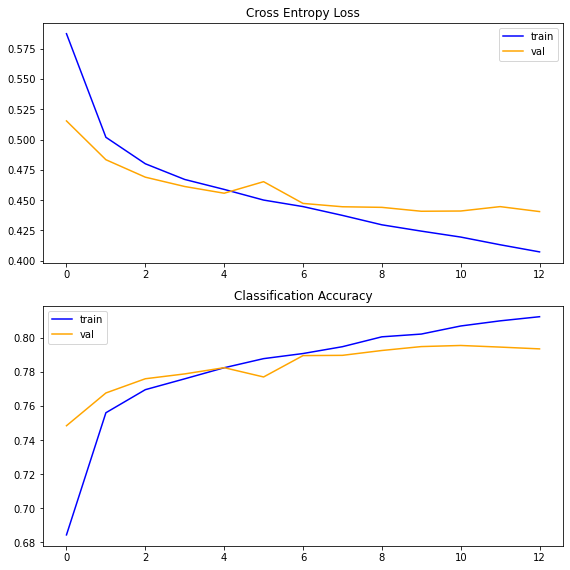

In [41]:
summarize_diagnostics(history)

### Evaluate

In [42]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [43]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 10s 13ms/step - loss: 0.4410 - accuracy: 0.7956


[0.4410381317138672, 0.7955999970436096]

In [44]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 3s 3s/step


array([[0.06537156],
       [0.955713  ]], dtype=float32)

625/625 [==============================] - 9s 15ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- ArchiREF ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8765
                  F1 : 0.7908
            ACCURACY : 0.7956
           PRECISION : 0.8099
              RECALL : 0.7726
   AVERAGE_PRECISION : 0.8795

       TRAINING-TIME : 339.8483
      INFERENCE-TIME : 9.5038

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.82      0.80     10000
Prediction = 1       0.81      0.77      0.79     10000

      accuracy      

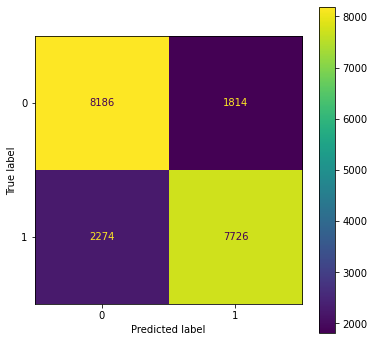

--- ROC AUC ---------------------------------------------------------------------------------------- 



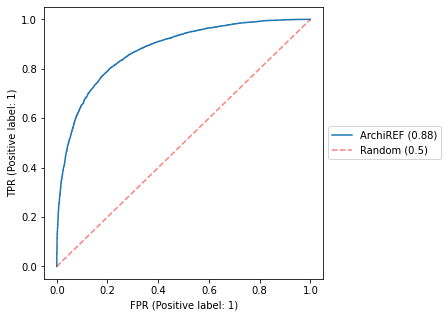

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



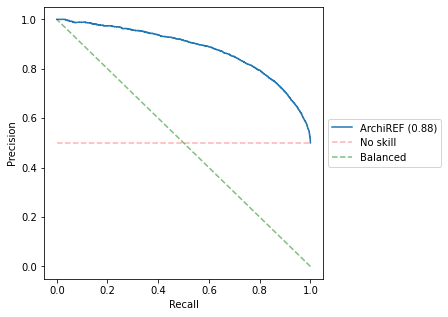

In [45]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [46]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 8s 13ms/step
The best Accuracy score (0.7973) for this model is reached with a threshold of 0.468


625/625 [==============================] - 8s 12ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- ArchiREF [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8765
                  F1 : 0.7953
            ACCURACY : 0.7956
           PRECISION : 0.7968
              RECALL : 0.7937
   AVERAGE_PRECISION : 0.8795

       TRAINING-TIME : 339.8483
      INFERENCE-TIME : 8.0228

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.80      0.80     10000
Prediction = 1       0.80      0.79      0.80     10000

      accuracy      

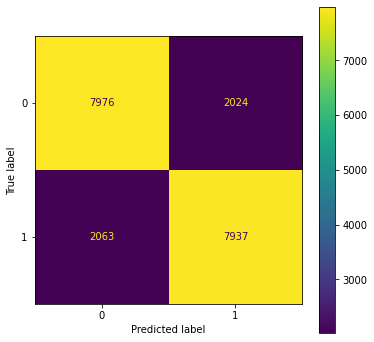

In [47]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [48]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [49]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760


---
## 2.2 `Archi-000` Dense 32 + Dropout 0.5 <a class="anchor" id="ARCHI_000"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi000"
model, archi_desc = architecture000("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.3 `Archi-100` Simple RNN 32 + Dropout 0.5 <a class="anchor" id="ARCHI_100"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi100"
model, archi_desc = architecture100("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.4 `Archi-200` LSTM 32 + Dropout 0.5 <a class="anchor" id="ARCHI_200"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi200"
model, archi_desc = architecture200("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.5 `Archi-300` GRU 32 + Dropout 0.5 <a class="anchor" id="ARCHI_300"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi300"
model, archi_desc = architecture300("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.6 `Archi-201` Bi-LSTM 64 + Dropout 0.5 <a class="anchor" id="ARCHI_201"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi201"
model, archi_desc = architecture201("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.7 `Archi-202` Bi-LSTM 64 + Dense 24 <a class="anchor" id="ARCHI_202"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi202"
model, archi_desc = architecture202("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.8 `Archi-301` Bi-GRU 64 + Dropout 0.5 <a class="anchor" id="ARCHI_301"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi301"
model, archi_desc = architecture301("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.9 `Archi-302` Bi-GRU 64 + Dense 24 <a class="anchor" id="ARCHI_302"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi302"
model, archi_desc = architecture302("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.10 `Archi-401` Bi-LSTM 32 + Dense 10 <a class="anchor" id="ARCHI_401"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi401"
model, archi_desc = architecture401("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.11 `Archi-402` Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1 <a class="anchor" id="ARCHI_402"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi402"
model, archi_desc = architecture402("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.12 `Archi-403` Dense 128 + Dropout 0.2 + Dense 64 + Dropout 0.2 + Dense 32 + Dropout 0.1 <a class="anchor" id="ARCHI_403"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi403"
model, archi_desc = architecture403("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.13 Comparaison des `scores` avec les différentes architectures <a class="anchor" id="ARCHI_scores"></a> [⇪](#menu)

In [ ]:
from classification_utils import scores_df

In [ ]:
scores_df.sort_values(['ROC AUC'], ascending=False)

In [ ]:
scores_df.sort_values(['Accuracy'], ascending=False)

In [ ]:
import FreeMobileSMS as sms
sms.send(stop=False)